# Evaluate ASR algorithm in motion artifacts removal

In [23]:
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.manifold import TSNE

In [24]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
def extract_average_metrics(report):
    average_metrics = report['weighted avg'] 
    return average_metrics['precision'], average_metrics['recall'], average_metrics['f1-score']

def map_labels(y, classes):
    return y.map(classes)

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{height:.2f}', ha='center', va='bottom', fontsize=13)

## Preparing Data

### Merge classes

In [26]:
# dir_names = ['1712094934_Nhan', '1712270250_Onila', '1712262127_Brian', '1713293584_Jacob', '1713458084_Andrei', '1713550894_AlexKagoda']
dir_names = ['1712094934_Nhan', '1712270250_Onila', '1712262127_Brian', '1713293584_Jacob', '1713458084_Andrei', '1713550894_AlexKagoda', '1713820773_Andrew', '1713994149_Saad', '1714511822_Nathan']

drop_columns = ['Index', 'Labels', 'EDA-Skew', 'EDA-Kurt']
Xs = []

new_classes = {
                '5 levels':{
                    'order':{1: 1, 2: 2, 3: 3, 4: 4, 5: 5},
                    'labels':[],
                    'accuracy':[],
                    'precision':[],
                    'recall':[],
                    'Class Metrics': {str(i): {'Precision': [], 'Recall': [], 'F1-Score': []} for i in range(1,6)}
                },
                '4 levels':{
                    'order':{1: 1, 2: 2, 3: 2, 4: 3, 5: 4},
                    'labels':[],
                    'accuracy':[],
                    'precision':[],
                    'recall':[],
                    'Class Metrics': {str(i): {'Precision': [], 'Recall': [], 'F1-Score': []} for i in range(1,5)}
                },
                # '3 levels: 1+2+3':{
                #     'order':{1: 1, 2: 1, 3: 1, 4: 2, 5: 3},
                #     'labels':[],
                #     'accuracy':[],
                #     'precision':[],
                #     'recall':[],
                #     'Class Metrics': {str(i): {'Precision': [], 'Recall': [], 'F1-Score': []} for i in range(1,4)}
                # },
                '3 levels':{
                    'order':{1: 1, 2: 2, 3: 2, 4: 3, 5: 3},
                    'labels':[],
                    'accuracy':[],
                    'precision':[],
                    'recall':[],             
                    'Class Metrics': {str(i): {'Precision': [], 'Recall': [], 'F1-Score': []} for i in range(1,4)}       
                }
            }   

combined_X = pd.DataFrame()
scaler = StandardScaler()
for dir_name in dir_names:
    df = pd.read_csv(f'data1/logging/{dir_name}/vestibular_features_short_20s_stridebase10s_stridestinm1s.csv')
    df = df[df['Labels'] != 0.0]
    X_temp = df.drop(drop_columns, axis=1)
    
    for merge in new_classes:
        Y_temp = map_labels(df['Labels'], new_classes[merge]['order'])
        new_classes[merge]['labels'].append(Y_temp)
    
    # Normalize each dataset individually
    # X_normalized = scaler.fit_transform(X_temp)
    # Xs.append(X_normalized)
    
    # Merge before normalizing
    combined_X = pd.concat([combined_X, X_temp], axis=0, ignore_index=True)
    Xs.append(X_temp)

###################################################
X_normalized = scaler.fit_transform(combined_X)
X = X_normalized

###################################################

# Concatenate all normalized features and labels
X_nan = pd.concat([pd.DataFrame(data=x) for x in Xs], axis=0, ignore_index=True)
nan_columns = X_nan.columns[X_nan.isna().any()].tolist()
print("Features with NaNs:", nan_columns)
nan_rows = X_nan[X_nan.isna().any(axis=1)].index.tolist()
print("Indices with NaNs:", nan_rows)
for merge in new_classes:
    new_classes[merge]['labels'] = pd.concat(new_classes[merge]['labels'], axis=0, ignore_index=True)

Features with NaNs: []
Indices with NaNs: []


### Plot the counter for each level

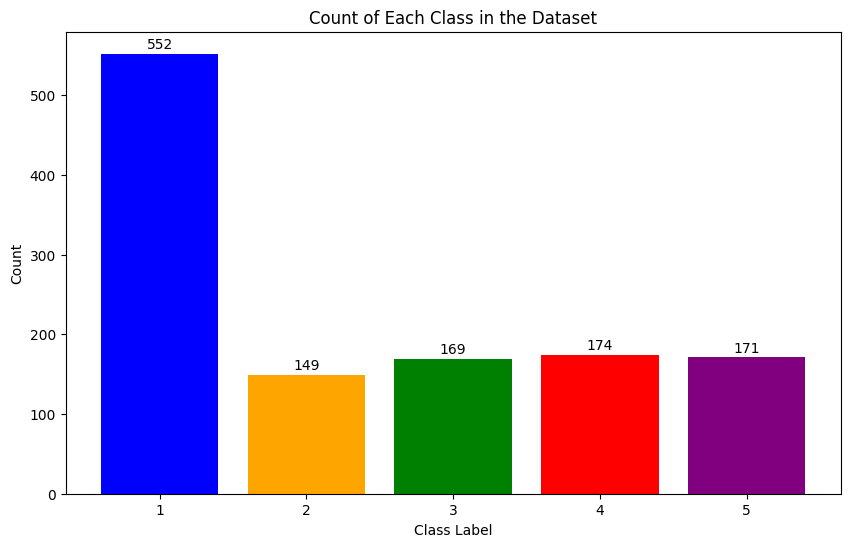

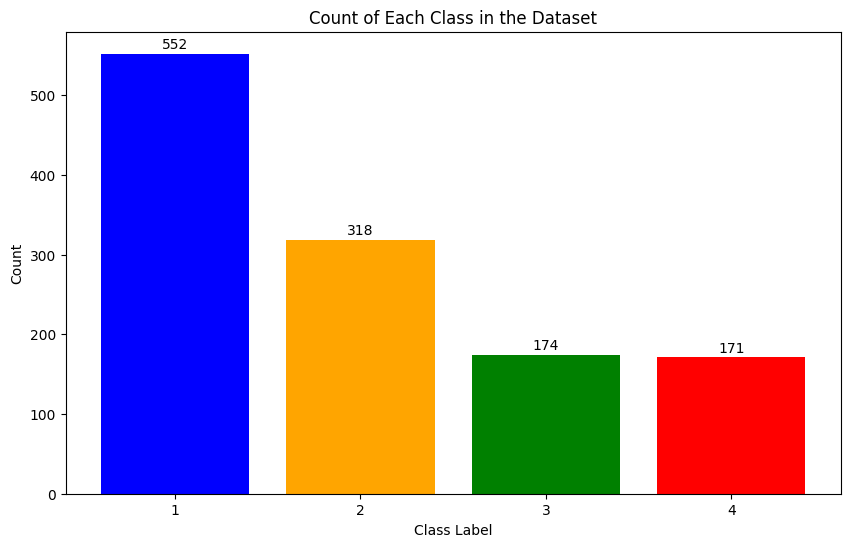

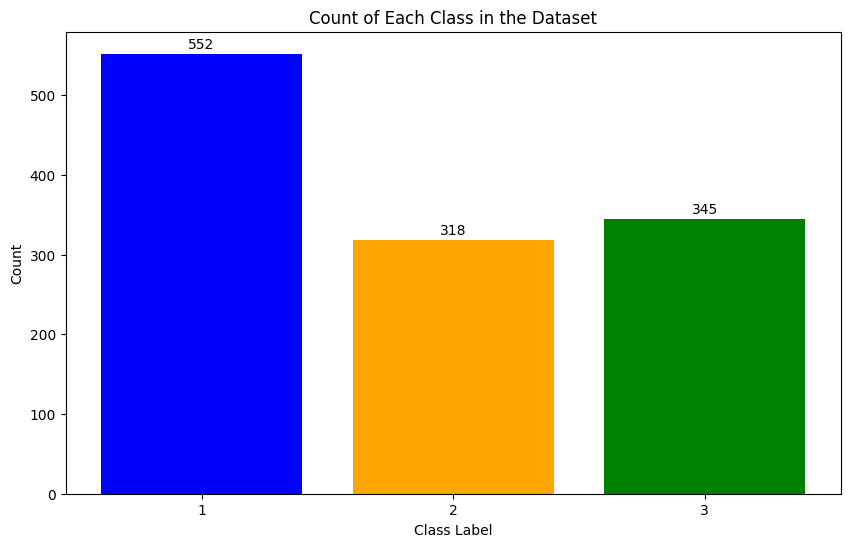

In [27]:
for merge in new_classes:
    Y = new_classes[merge]['labels']
    unique, counts = np.unique(Y, return_counts=True)

    plt.figure(figsize=(10, 6))
    bars = plt.bar(unique, counts, color=['blue', 'orange', 'green', 'red', 'purple'])
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 3, yval, ha='center', va='bottom')
        
    plt.xlabel('Class Label')
    plt.ylabel('Count')
    plt.title('Count of Each Class in the Dataset')
    plt.xticks(unique)
    plt.show()

### Nothing, original data

In [28]:
X_resample = {}
Y_resample = {}

for merge in new_classes:
    X_resample[merge] = X
    Y_resample[merge] = new_classes[merge]['labels']

### Try resample()

In [29]:
# from sklearn.utils import resample
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# X_resample = {}
# Y_resample = {}

# for merge in new_classes:
#     Y = new_classes[merge]['labels']
#     df_train = pd.DataFrame(Y, columns=['Labels'])
#     unique_labels = df_train['Labels'].unique()
#     majority_class = df_train['Labels'].value_counts().idxmax()  # Identify the majority class
#     majority_count = df_train['Labels'].value_counts().max()     # Count of the majority class

#     # Downsample the majority class
#     df_majority_downsampled = resample(df_train[df_train['Labels'] == majority_class],
#                                        replace=False,
#                                        n_samples=int(majority_count * 0.5),  # For example, downsample to 50% of the majority count
#                                        random_state=42)

#     # Prepare the final data by including the downsampled majority and all of the minority data
#     df_minorities = df_train[df_train['Labels'] != majority_class]  # Data from minority classes

#     # Combine downsampled majority class with unchanged minorities
#     df_resampled = pd.concat([df_majority_downsampled, df_minorities])

#     # Shuffle the data to avoid having all samples from one class grouped together
#     df_resampled = df_resampled.sample(frac=1, random_state=42)  # Shuffle the rows

#     X_resampled = X[df_resampled.index]  # Assuming 'X' is defined and matches the indices of 'df_train'
#     Y_resampled = df_resampled['Labels'].values

#     # Store resampled data in dictionaries
#     X_resample[merge] = X_resampled
#     Y_resample[merge] = Y_resampled

#     # The count for each class after resampling
#     class_distribution_resampled = pd.Series(Y_resampled).value_counts()

#     # Let's plot the distribution of the classes after resampling
#     plt.figure(figsize=(10, 6))
#     resampled_bars = plt.bar(class_distribution_resampled.index, class_distribution_resampled.values,
#                              color=['blue', 'orange', 'green', 'red', 'purple'])

#     for bar in resampled_bars:
#         yval = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

#     plt.xlabel('Class Label')
#     plt.ylabel('Count')
#     plt.title(f'Resampled Class Distribution - {merge}')
#     plt.xticks(class_distribution_resampled.index)  # Ensure only the unique labels are used as x-ticks
#     plt.show()


### SMOTE

In [30]:
# from imblearn.over_sampling import SMOTE

# X_resample = {}
# Y_resample = {}

# for merge in new_classes:
#     X_merge = X
#     Y_merge = new_classes[merge]['labels']
    
#     sm = SMOTE()
#     oversampled_X, oversampled_Y = sm.fit_resample(X_merge, Y_merge)

#     X_resample[merge] = oversampled_X
#     Y_resample[merge] = oversampled_Y
#     print(Y_resample[merge].shape, X_resample[merge].shape)


### Do some feature analysis here, like figure 2 in the the paper "A pilot study of the Earable device to measure facial muscle and eye movement tasks among healthy volunteers"

### Correlation map

## 1. L1-based Feature Selection


In [31]:
# X_l1 = {}
# for merge in new_classes:
#     X_merge = X_resample[merge]
#     Y_merge = Y_resample[merge]
    
#     desired_features_count = 20 
#     tolerance = 1 
#     features_count = 0
#     C_values = np.logspace(-1, 0, 10)

#     for C in reversed(C_values):  # Start from smaller penalty (larger C values mean weaker penalty)
#         logistic = LogisticRegression(C=C, penalty='l1', solver='liblinear', multi_class='ovr')
#         model = SelectFromModel(logistic)
#         model.fit(X_merge, Y_merge)
#         selected_features = np.sum(model.get_support())
#         print(f"C={C:.4f}, selected features={selected_features}")

#         if abs(selected_features - desired_features_count) <= tolerance:
#             break 

#     logistic = LogisticRegression(C=C, penalty='l1', solver='liblinear', multi_class='ovr')
#     model = SelectFromModel(logistic)
#     model.fit(X_merge, Y_merge)
#     X_l1[merge] = model.transform(X_merge)
#     print("Selected features by L1:", X_temp.columns[model.get_support()])

In [32]:
# # Plotting
# plt.figure(figsize=(5, 5))
# bar_positions = np.arange(3)
# bar_heights = [80, 77, 71]
# bars = plt.bar(bar_positions, bar_heights, color='r', width=0.5)

# plt.xticks(bar_positions, X_l1.keys(), rotation=45, fontsize=20)

# ax = plt.gca()  # Get current axes
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# # Only show ticks on the left and bottom spines
# ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_ticks_position('bottom')

# for bar in bars:
#     yval = bar.get_height()
#     plt.text(bar.get_x() + bar.get_width()/4, yval + 1, yval, ha='center', va='bottom', fontsize=15)

# # plt.xlabel('Merge Iterations', fontsize=20)
# plt.ylabel('Number of Selected Features', fontsize=20)
# plt.title('Number of Selected Features by L1 Penalty per Merge', fontsize=20)
# plt.tight_layout()  # Adjust layout to not cut off labels
# ax.tick_params(axis='both', labelsize=16)  # Adjust the size as needed

# plt.savefig(f'figures/l1_feature_selection.svg', format='svg', bbox_inches='tight')


# plt.show()

In [33]:
# pca_l1 = {}

# for merge in new_classes:
#     X_l1_merge = X_l1[merge]
#     Y_merge = Y_resample[merge]
    
#     pca = PCA(n_components=2)
#     pc = pca.fit_transform(X_l1_merge)
#     pca_l1[merge] = pc

#     plt.figure(figsize=(5, 5))
#     scatter = plt.scatter(pc[:, 1], pc[:, 0], c=Y_merge, cmap='viridis', alpha=0.6)
#     plt.title(f'PCA - L1 Logistic Reression - {merge}')
#     plt.xlabel('2nd Principal component')
#     plt.ylabel('1st Principal component')
#     plt.legend(*scatter.legend_elements(), title="Dizziness Level")
#     plt.show()

## 2. Tree-based Feature Selection

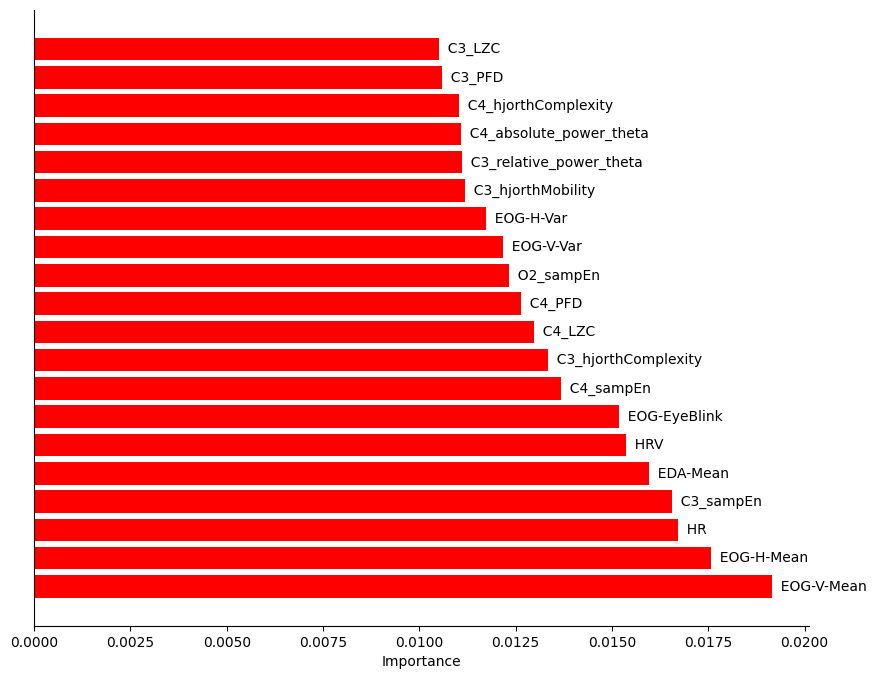

[[-0.33952591 -0.20810023 -0.1319027  ...  0.462619   -0.0389468
  -0.99138539]
 [-0.38557095 -0.24264925 -0.15178227 ...  0.45930499 -0.03894246
  -0.99131835]
 [-0.38740796 -0.23864661 -0.15787847 ...  0.45701204 -0.03894915
  -0.99001411]
 ...
 [ 0.37455585  0.06902721 -0.08918259 ...  1.02177298  0.0276395
  -0.39745502]
 [ 0.29405682 -0.0162531  -0.08868404 ...  1.00815482  0.02220665
  -0.39363613]
 [ 0.10970424 -0.08924608 -0.03099304 ...  1.01358591  0.02477945
  -0.38886921]]


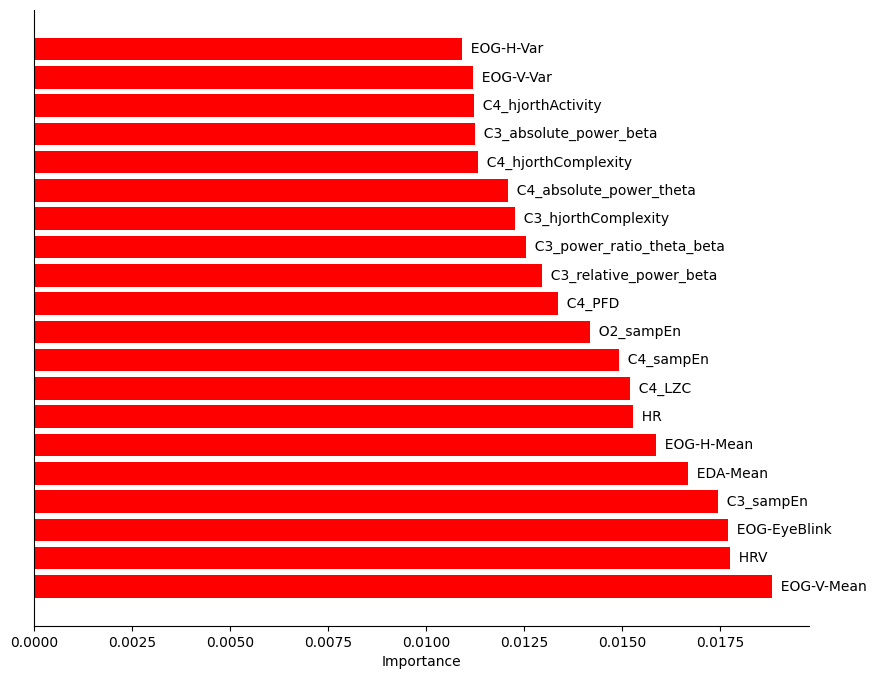

[[-0.33952591 -0.15371029 -0.29094624 ...  0.462619   -0.0389468
  -0.99138539]
 [-0.38557095 -0.19380083 -0.30991297 ...  0.45930499 -0.03894246
  -0.99131835]
 [-0.38740796 -0.18609202 -0.31393435 ...  0.45701204 -0.03894915
  -0.99001411]
 ...
 [ 0.37455585  0.83133452  0.28933453 ...  1.02177298  0.0276395
  -0.39745502]
 [ 0.29405682  0.63977109  0.19875598 ...  1.00815482  0.02220665
  -0.39363613]
 [ 0.10970424  0.34353311  0.03338993 ...  1.01358591  0.02477945
  -0.38886921]]


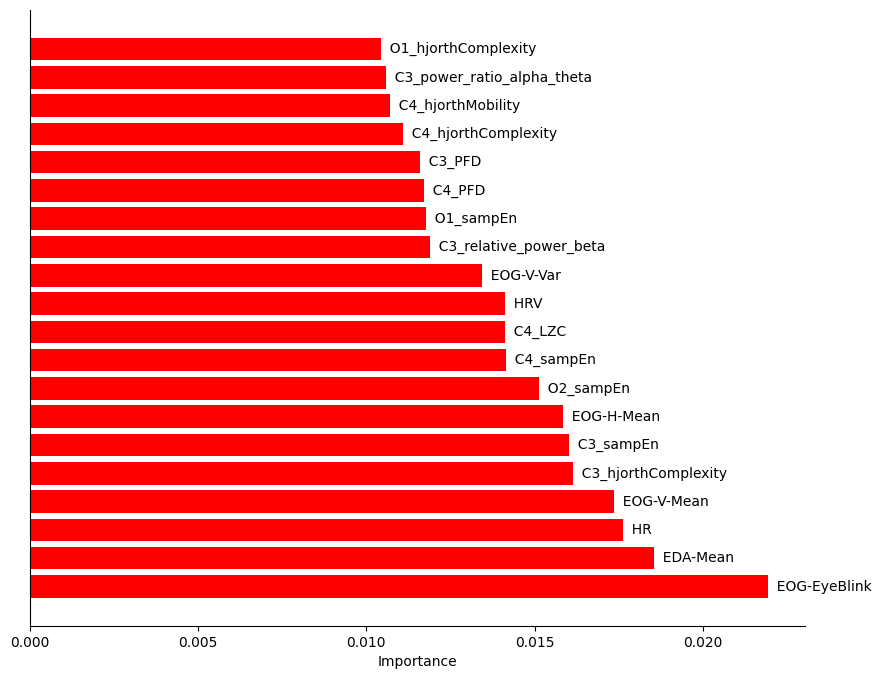

[[-0.20740507 -0.09092684 -0.15371029 ... -0.0389468   1.90140517
  -0.99138539]
 [-0.23398415 -0.15547088 -0.19380083 ... -0.03894246  2.87877063
  -0.99131835]
 [-0.21021036 -0.1506166  -0.18609202 ... -0.03894915  0.91207747
  -0.99001411]
 ...
 [ 1.9966572  -0.00971015  0.83133452 ...  0.0276395  -0.52041846
  -0.39745502]
 [ 1.71032424 -0.00768285  0.63977109 ...  0.02220665 -0.49331099
  -0.39363613]
 [ 1.13015433  0.0322593   0.34353311 ...  0.02477945 -0.50783197
  -0.38886921]]


In [34]:
X_tree = {}
for merge in new_classes:
    X_merge = X_resample[merge]
    Y_merge = Y_resample[merge]
    
    tree = ExtraTreesClassifier(n_estimators=100, class_weight='balanced')
    tree = tree.fit(X_merge, Y_merge)
    model = SelectFromModel(tree, prefit=True)
    X_tree[merge] = model.transform(X_merge)

    # print("Selected features by Tree-based method:", X_temp.columns[model.get_support()])
    
    # Visualize
    feature_names = X_temp.columns

    importances = tree.feature_importances_
    indices = np.argsort(importances)[101:][::-1]
    sorted_feature_names = [feature_names[i] for i in indices]


    plt.figure(figsize=(10, 8))
    bars = plt.barh(range(len(importances[101:])), importances[indices], color="r", align="center")
    plt.xlabel('Importance')

    plt.yticks([])  # Hide y-axis ticks

    # Annotate with the feature names
    for bar, feature_name in zip(bars, sorted_feature_names):
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'  {feature_name}', 
                va='center', ha='left', color='black')

    # Hide the right and top spines
    ax = plt.gca()  # Get current axes
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.savefig('figures/feature_importance.svg', format='svg', bbox_inches='tight')

    plt.show()
    print(X_tree[merge])

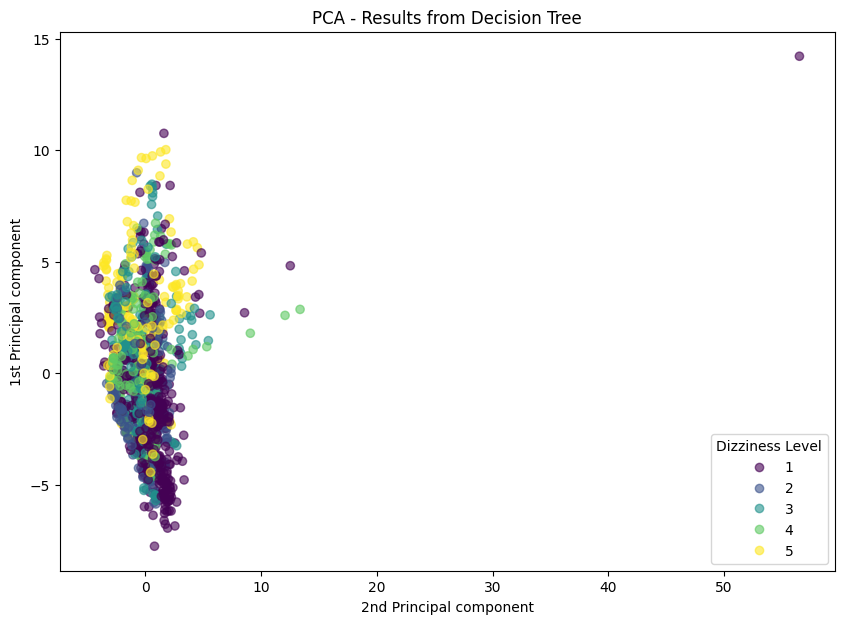

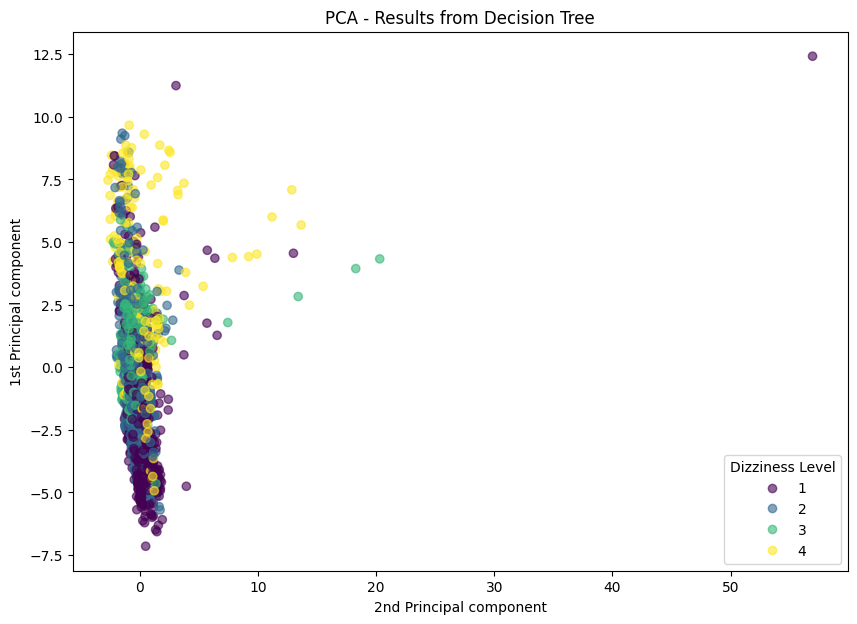

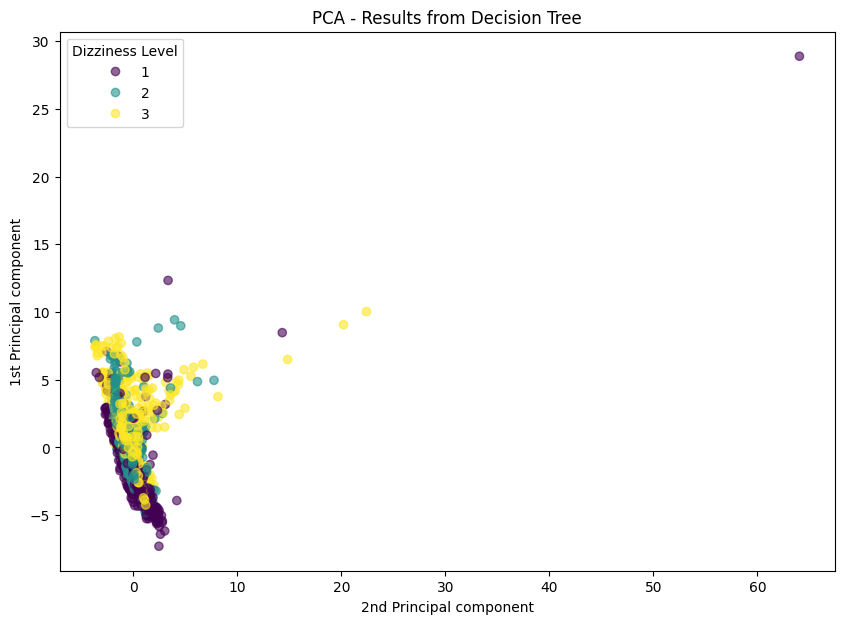

In [35]:
pca_tree = {}

for merge in new_classes:
    X_tree_merge = X_tree[merge]
    Y_merge = Y_resample[merge]
    
    pca = PCA(n_components=2)
    pc = pca.fit_transform(X_tree_merge)
    pca_tree[merge] = pc

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(pc[:, 1], pc[:, 0], c=Y_merge, cmap='viridis', alpha=0.6)
    plt.title('PCA - Results from Decision Tree')
    plt.xlabel('2nd Principal component')
    plt.ylabel('1st Principal component')
    plt.legend(*scatter.legend_elements(), title="Dizziness Level")
    plt.show()

### 4. PCA on the entire data

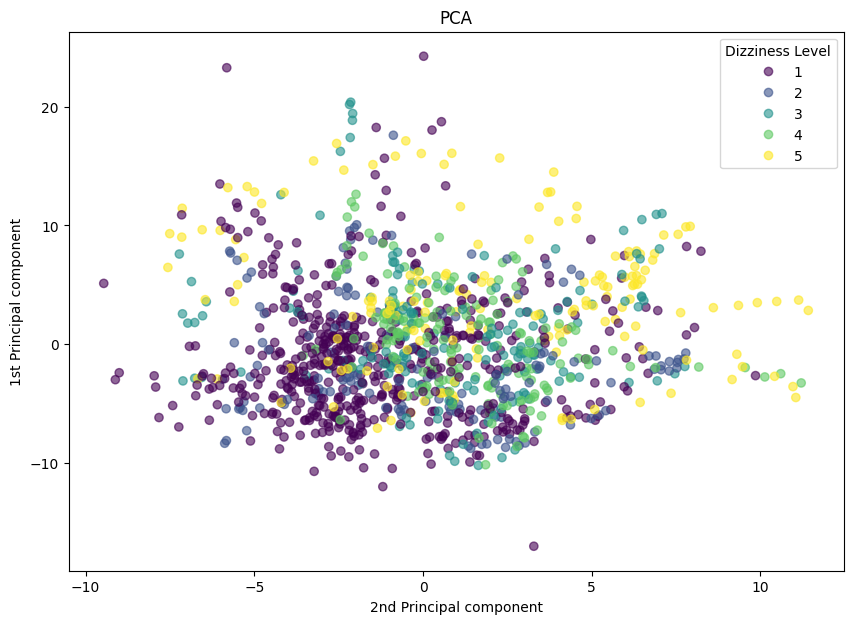

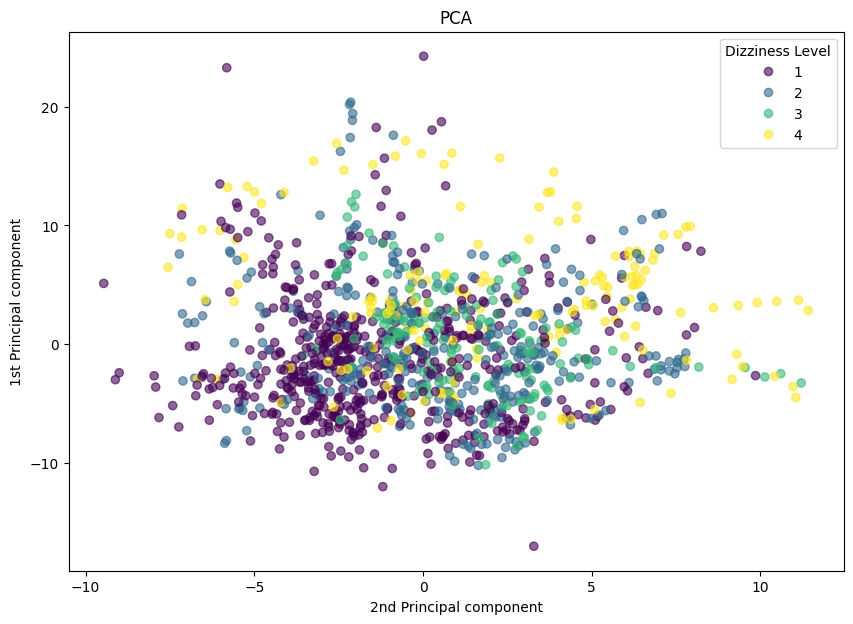

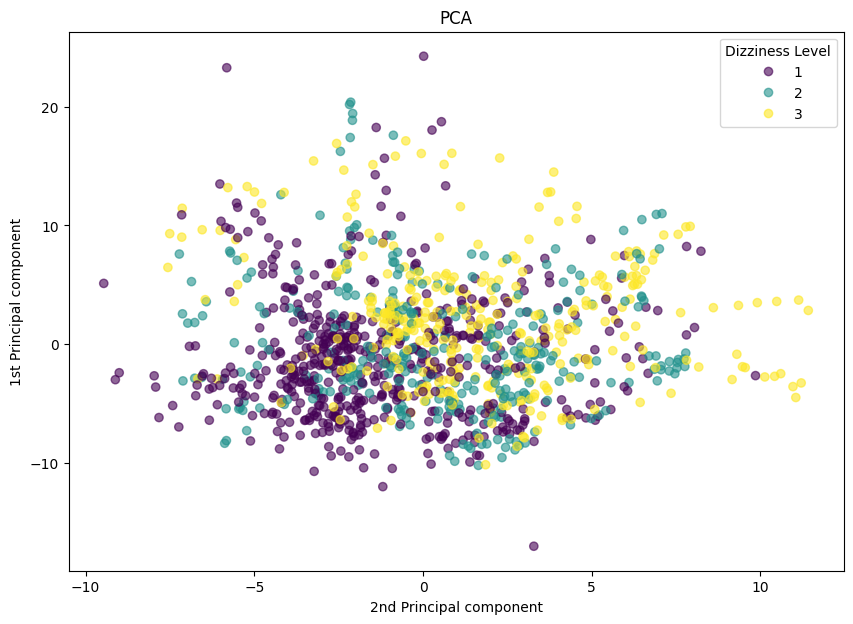

In [36]:
pca_entire = {}
for merge in new_classes:
    X_merge = X_resample[merge]
    Y_merge = Y_resample[merge]
    
    pca = PCA(n_components=2)
    pc = pca.fit_transform(X_merge)
    pca_entire[merge] = pc

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(pc[:, 1], pc[:, 0], c=Y_merge, cmap='viridis', alpha=0.6)
    plt.title('PCA')
    plt.xlabel('2nd Principal component')
    plt.ylabel('1st Principal component')
    plt.legend(*scatter.legend_elements(), title="Dizziness Level")
    plt.show()

### 5. Linear Discriminant 

C:\Users\Nhan\AppData\Local\Temp\ipykernel_23884\1288153242.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_lda[mask, 0], np.zeros_like(X_lda[mask, 0]) if X_lda.shape[1] == 1 else X_lda[mask, 1]


figures/lda_5 levels.svg


C:\Users\Nhan\AppData\Local\Temp\ipykernel_23884\1288153242.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_lda[mask, 0], np.zeros_like(X_lda[mask, 0]) if X_lda.shape[1] == 1 else X_lda[mask, 1]


figures/lda_4 levels.svg


C:\Users\Nhan\AppData\Local\Temp\ipykernel_23884\1288153242.py:18: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_lda[mask, 0], np.zeros_like(X_lda[mask, 0]) if X_lda.shape[1] == 1 else X_lda[mask, 1]


figures/lda_3 levels.svg


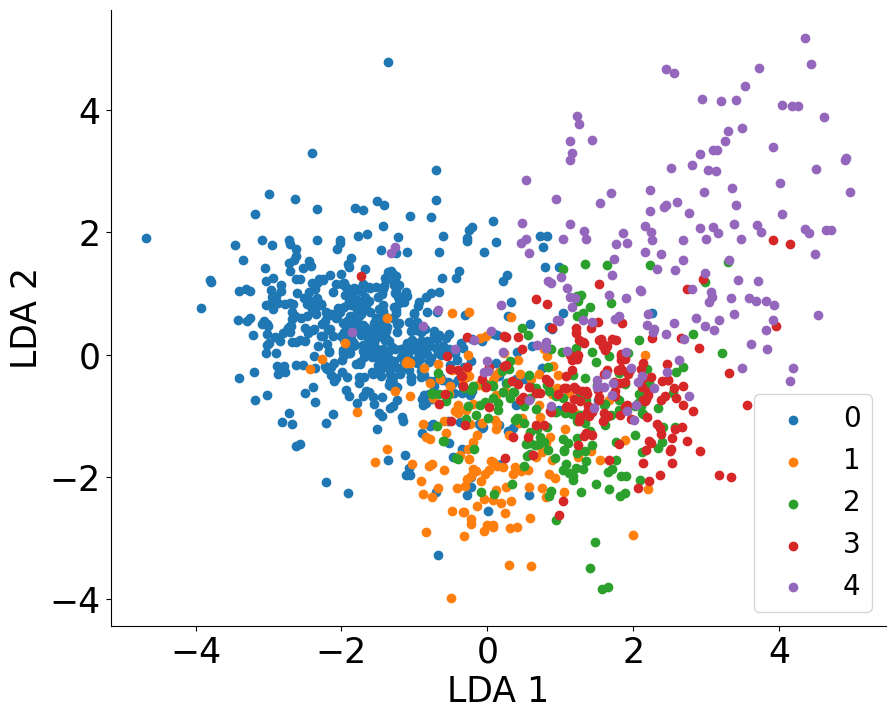

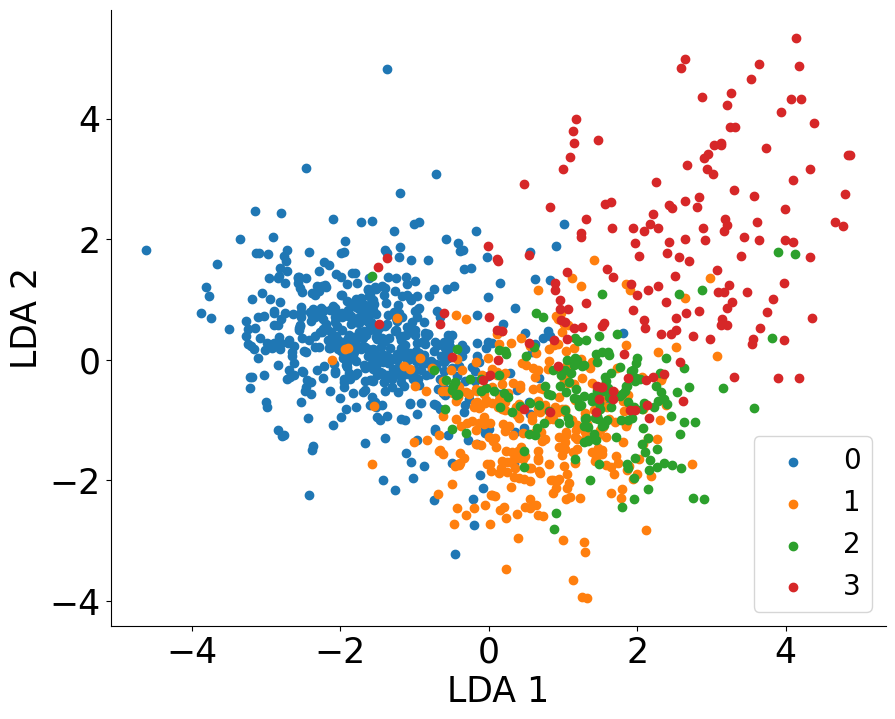

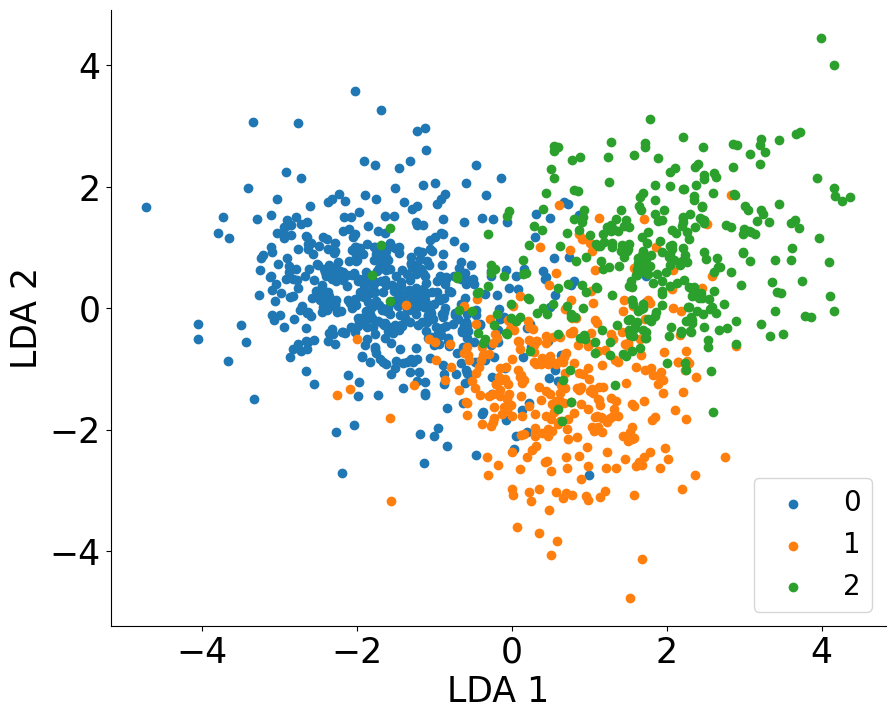

In [43]:
lda_output = {}
idx = 5
for merge in new_classes:
    X_merge = X_resample[merge]
    Y_merge = Y_resample[merge]

    # lda = LDA(n_components=2, solver='svd')
    lda = LDA(solver='svd')

    X_lda = lda.fit_transform(X_merge, Y_merge)
    
    lda_output[merge] = X_lda
    
    plt.figure(figsize=(10, 8))
    unique_labels = np.unique(Y_merge) 
    for i, label in enumerate(unique_labels):
        mask = Y_merge == label  # Create a mask for the current class
        plt.scatter(X_lda[mask, 0], np.zeros_like(X_lda[mask, 0]) if X_lda.shape[1] == 1 else X_lda[mask, 1]
                    , cmap='viridis', label=f'{label-1}')

    # Hide the right and top spines
    ax = plt.gca()  # Get current axes
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)

    # plt.title(f'LDA Projection')
    plt.xlabel('LDA 1', fontsize=25)
    plt.ylabel('LDA 2' if X_lda.shape[1] > 1 else '', fontsize=25)
    plt.legend(loc='lower right', fontsize=20) 

    plt.yticks([]) if X_lda.shape[1] == 1 else plt.ylabel('LDA 2')
    nam = f'figures/lda_{merge}.svg'
    print(nam)
    plt.savefig(f'figures/lda_{idx}.svg', format='svg', bbox_inches='tight')
    idx-=1
    # plt.show()


### Training and testimg

In [38]:
import seaborn as sns


######### 5 levels #########
###################### SVM - 5 levels ####################
Average Accuracy: 0.8204985774285328
Average Precision: 0.7892077423917643
Average Recall: 0.8059148416942534
Class 1 - Precision: 0.93906818287428, Recall: 0.8531818181818182, F1-Score: 0.8934924321647733
Class 2 - Precision: 0.6525190876661464, Recall: 0.8123809523809523, F1-Score: 0.715953699457423
Class 3 - Precision: 0.7645111553393287, Recall: 0.7466911764705882, F1-Score: 0.7468236669175449
Class 4 - Precision: 0.7323439054215404, Recall: 0.8333333333333334, F1-Score: 0.7765525670652907
Class 5 - Precision: 0.8575963806575262, Recall: 0.7839869281045753, F1-Score: 0.8169343578095949
###################### Decision Tree - 5 levels ####################
Average Accuracy: 0.7768256333830105
Average Precision: 0.7371709669143928
Average Recall: 0.7383830956625074
Class 1 - Precision: 0.8751525683849417, Recall: 0.8567532467532468, F1-Score: 0.8654253001834409
Class 2 - Precision: 0.663924956622325

C:\Users\Nhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


###################### Logistic Regression - 5 levels ####################
Average Accuracy: 0.8106015445061645
Average Precision: 0.7786388355367051
Average Recall: 0.7740518419489008
Class 1 - Precision: 0.8968922033084595, Recall: 0.8912337662337662, F1-Score: 0.8934365116437373
Class 2 - Precision: 0.6959923991893302, Recall: 0.7728571428571428, F1-Score: 0.7266794041963821
Class 3 - Precision: 0.7302316397053239, Recall: 0.6761029411764706, F1-Score: 0.6958559317027058
Class 4 - Precision: 0.7385312713602187, Recall: 0.769934640522876, F1-Score: 0.7494678018871568
Class 5 - Precision: 0.8315466641201935, Recall: 0.7601307189542484, F1-Score: 0.7905206992564678


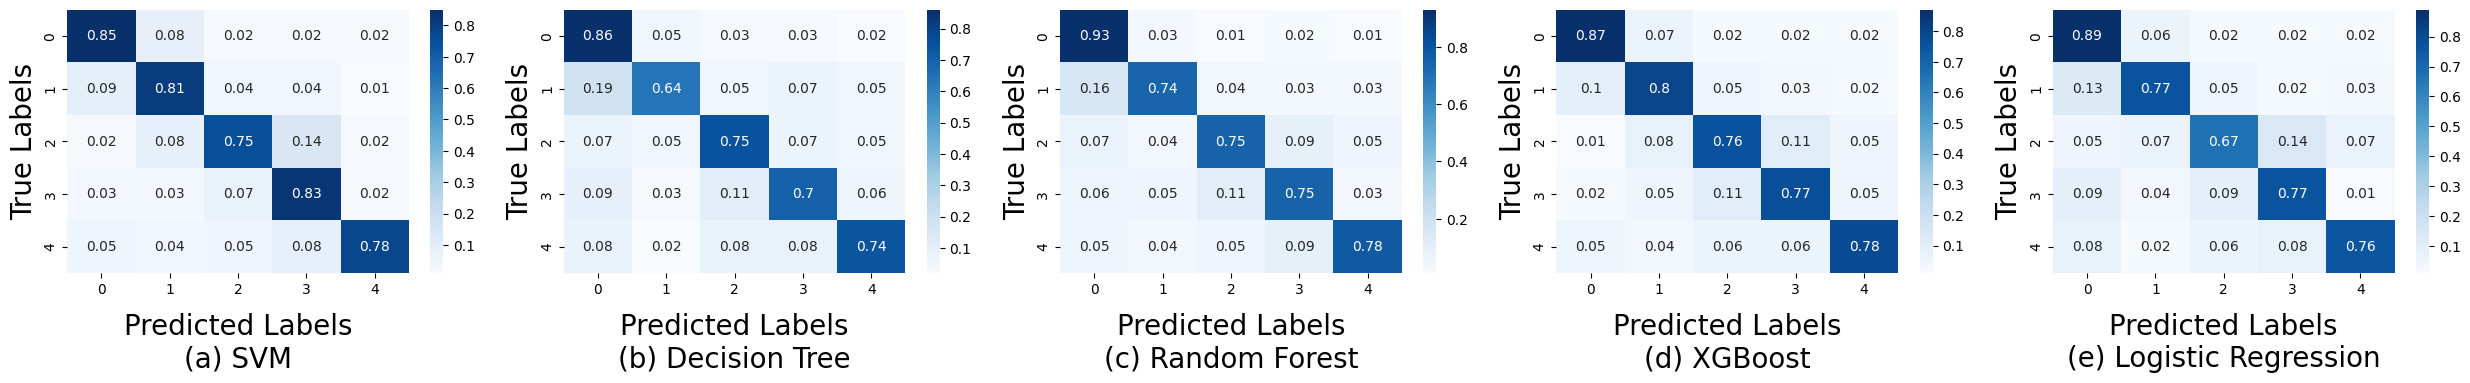

#########################################################

######### 4 levels #########
###################### SVM - 4 levels ####################
Average Accuracy: 0.8394323262430564
Average Precision: 0.816040285305361
Average Recall: 0.8316491365607828
Class 1 - Precision: 0.9428392599552664, Recall: 0.8766558441558441, F1-Score: 0.9075962678194245
Class 2 - Precision: 0.7789607877822546, Recall: 0.7764112903225806, F1-Score: 0.7749023127746005
Class 3 - Precision: 0.7364129474270812, Recall: 0.8673202614379086, F1-Score: 0.7941256622318316
Class 4 - Precision: 0.8059481460568417, Recall: 0.8062091503267974, F1-Score: 0.7971271292833262
###################### Decision Tree - 4 levels ####################
Average Accuracy: 0.7662511854762227
Average Precision: 0.7386798244281534
Average Recall: 0.7280841148165034
Class 1 - Precision: 0.8620896425810229, Recall: 0.8639935064935065, F1-Score: 0.8619705630583466
Class 2 - Precision: 0.7092254226251905, Recall: 0.6908266129032258, F1-Sco

C:\Users\Nhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


###################### Logistic Regression - 4 levels ####################
Average Accuracy: 0.825416610215418
Average Precision: 0.8105831876061547
Average Recall: 0.8027493434446115
Class 1 - Precision: 0.8897910991488265, Recall: 0.8966558441558442, F1-Score: 0.891876618792633
Class 2 - Precision: 0.7849133391854062, Recall: 0.7450604838709678, F1-Score: 0.7614749917403493
Class 3 - Precision: 0.7534372473072162, Recall: 0.792483660130719, F1-Score: 0.7684513414002578
Class 4 - Precision: 0.81419106478317, Recall: 0.776797385620915, F1-Score: 0.7823257879950257


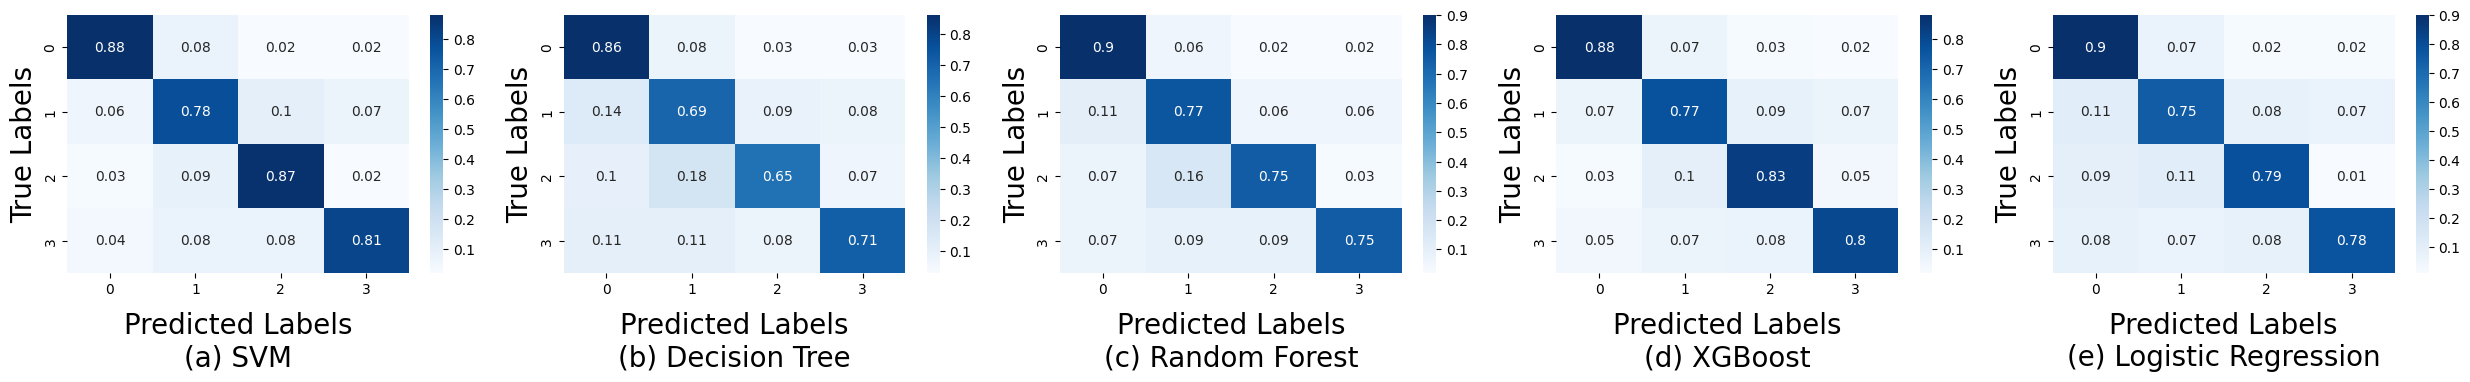

#########################################################

######### 3 levels #########
###################### SVM - 3 levels ####################
Average Accuracy: 0.8427855304159328
Average Precision: 0.8306111714665171
Average Recall: 0.8366942928197674
Class 1 - Precision: 0.9337668907253427, Recall: 0.8676623376623377, F1-Score: 0.8989877955377452
Class 2 - Precision: 0.7485888015493278, Recall: 0.798891129032258, F1-Score: 0.771292909173523
Class 3 - Precision: 0.809477822124881, Recall: 0.8435294117647059, F1-Score: 0.8246603354778758
###################### Decision Tree - 3 levels ####################
Average Accuracy: 0.7893713588944589
Average Precision: 0.7785062738962192
Average Recall: 0.7722045372401161
Class 1 - Precision: 0.8386988662424466, Recall: 0.8623051948051946, F1-Score: 0.849266720612374
Class 2 - Precision: 0.6973250545831191, Recall: 0.6824596774193548, F1-Score: 0.6880353239201736
Class 3 - Precision: 0.799494900863092, Recall: 0.7718487394957982, F1-Score: 

C:\Users\Nhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Nhan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


###################### Logistic Regression - 3 levels ####################
Average Accuracy: 0.8468703427719821
Average Precision: 0.8393746138645055
Average Recall: 0.8341017829419158
Class 1 - Precision: 0.8880595642308519, Recall: 0.9002597402597402, F1-Score: 0.8932964697277352
Class 2 - Precision: 0.8001609501609502, Recall: 0.7643145161290322, F1-Score: 0.7798361398528508
Class 3 - Precision: 0.8299033272017142, Recall: 0.8377310924369746, F1-Score: 0.8319091783006709


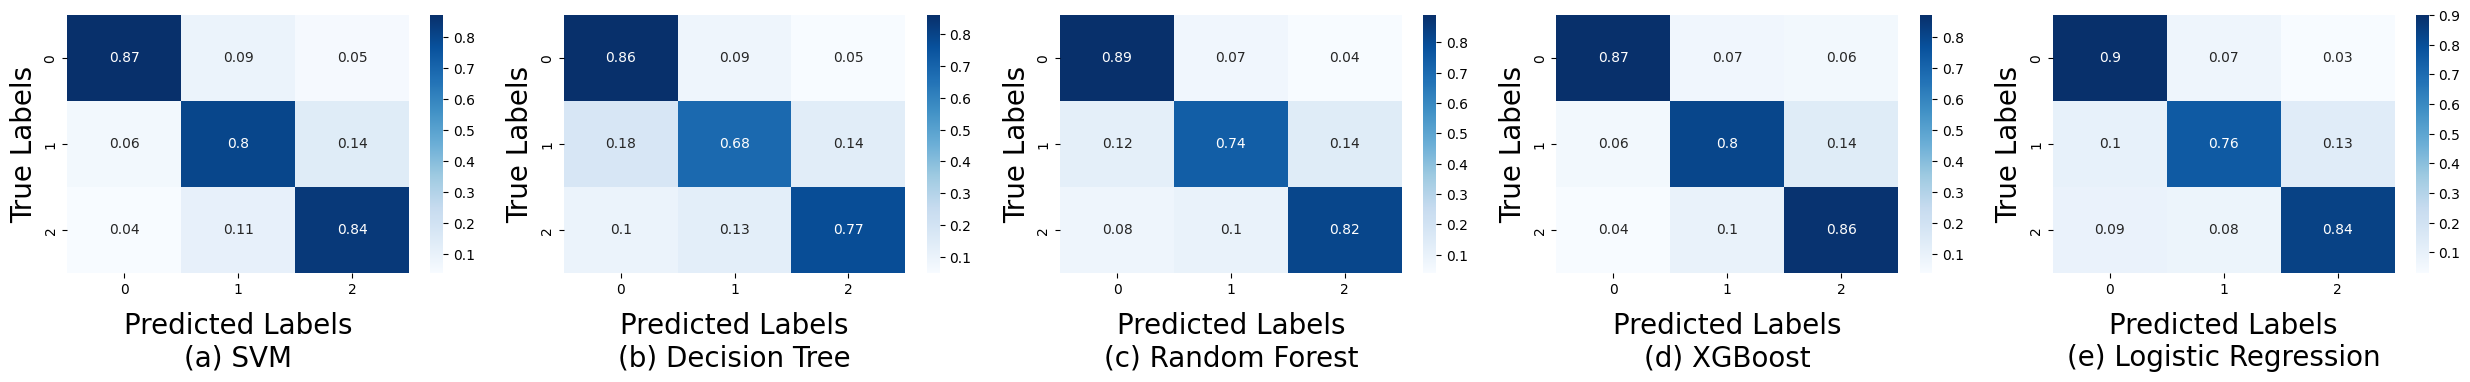

#########################################################



In [39]:
from sklearn.model_selection import StratifiedKFold
k = 10
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# from sklearn.model_selection import LeaveOneOut
# loo = LeaveOneOut()

for merge in new_classes:
    print(f'######### {merge} #########')
    Y_merge = Y_resample[merge]
    X_lda = lda_output[merge]

    models = {
        'SVM': SVC(kernel='rbf', class_weight='balanced'),
        'Decision Tree': DecisionTreeClassifier(random_state=42, criterion='log_loss', class_weight='balanced'),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, criterion='entropy', class_weight='balanced'),
        'XGBoost': xgb.XGBClassifier(objective='multi:softprob', max_depth=3, n_estimators=100, learning_rate=0.1, eval_metric='mlogloss', use_label_encoder=False, seed=42),
        'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
    }


    unique, counts = np.unique(Y_merge, return_counts=True)

    model_results = {name: {'Accuracy': [], 
                            'Precision': [], 
                            'Recall': [], 
                            'Confusion Matrix': [], 
                            'Class Metrics': {str(i): {'Precision': [], 'Recall': [], 'F1-Score': []} for i in unique}
    } for name in models.keys()}

    # Perform stratified k-fold cross-validation
    for train_index, test_index in kf.split(X_lda, Y_merge):
    # for train_index, test_index in loo.split(X_lda, Y_merge):
        for name, model in models.items():
            X_train, X_test = X_lda[train_index], X_lda[test_index]
            Y_train, Y_test = Y_merge[train_index], Y_merge[test_index]
            
            if name == 'XGBoost':
                Y_train = Y_train - 1
                Y_test = Y_test - 1
                sample_weights = compute_sample_weight(class_weight='balanced', y=Y_train)
                model.fit(X_train, Y_train, sample_weight=sample_weights, eval_set=[(X_test, Y_test)], verbose=False)
                Y_pred = model.predict(X_test)
            else:
                model.fit(X_train, Y_train)
                Y_pred = model.predict(X_test)

            accuracy = accuracy_score(Y_test, Y_pred)
            conf_matrix = confusion_matrix(Y_test, Y_pred)
            report = classification_report(Y_test, Y_pred, output_dict=True)

            model_results[name]['Accuracy'].append(accuracy)
            model_results[name]['Precision'].append(report['macro avg']['precision'])
            model_results[name]['Recall'].append(report['macro avg']['recall'])
            model_results[name]['Confusion Matrix'].append(conf_matrix)
            
            # Store class-specific metrics for each class
            for cl in unique:  # Adjust 'number_of_classes' as needed
                if str(cl) in report:
                    model_results[name]['Class Metrics'][str(cl)]['Precision'].append(report[str(cl)]['precision'])
                    model_results[name]['Class Metrics'][str(cl)]['Recall'].append(report[str(cl)]['recall'])
                    model_results[name]['Class Metrics'][str(cl)]['F1-Score'].append(report[str(cl)]['f1-score'])

            # # Store the performance of the models for the visualization later
            # new_classes[merge]['accuracy'].append(accuracy)
            # _precision, _recall, _f1_score = extract_average_metrics(report)
            # new_classes[merge]['precision'].append(_precision)
            # new_classes[merge]['recall'].append(_recall)

    fig, axes = plt.subplots(1, 5, figsize=(25, 4))  # Adjust the figure size as needed

    import string
    # Iterate through each model and their results
    for idx, (model_name, metrics) in enumerate(model_results.items()):
        print(f"###################### {model_name} - {merge} ####################")
        print("Average Accuracy:", np.mean(metrics['Accuracy']))
        print("Average Precision:", np.mean(metrics['Precision']))
        print("Average Recall:", np.mean(metrics['Recall']))
        
        # Calculate and print average class-specific metrics
        for cl, cls_metrics in metrics['Class Metrics'].items():
            avg_precision = np.mean(cls_metrics['Precision'])
            avg_recall = np.mean(cls_metrics['Recall'])
            avg_f1_score = np.mean(cls_metrics['F1-Score'])
            print(f"Class {cl} - Precision: {avg_precision}, Recall: {avg_recall}, F1-Score: {avg_f1_score}")
            
            new_classes[merge]['Class Metrics'][str(cl)]['Precision'].append(avg_precision)
            new_classes[merge]['Class Metrics'][str(cl)]['Recall'].append(avg_recall)
            new_classes[merge]['Class Metrics'][str(cl)]['F1-Score'].append(avg_f1_score)

        # Store the performance of the models for visualization later
        new_classes[merge]['accuracy'].append(np.mean(metrics['Accuracy']))
        new_classes[merge]['precision'].append(np.mean(metrics['Precision']))
        new_classes[merge]['recall'].append(np.mean(metrics['Recall']))
        
        # Calculate the average confusion matrix
        mean_conf_matrix = np.mean(metrics['Confusion Matrix'], axis=0)
        
        row_sums = mean_conf_matrix.sum(axis=1, keepdims=True)
        norm_conf_matrix = mean_conf_matrix / row_sums
        norm_conf_matrix = np.round(norm_conf_matrix, 2)

        # Plot the confusion matrix using seaborn on the respective subplot axis
        sns.heatmap(norm_conf_matrix, annot=True, fmt='g', cmap='Blues', ax=axes[idx])
        
        # Create a label for each subplot
        subplot_label = f"({string.ascii_lowercase[idx]}) {model_name}"

        # Place the subplot label below the x-axis label
        axes[idx].set_xlabel(f'Predicted Labels\n{subplot_label}', fontsize=20)
        axes[idx].set_ylabel('True Labels', fontsize=20)
        axes[idx].xaxis.set_label_coords(0.5, -0.15)  # Adjust the position of the xlabel
    

    plt.savefig(f'figures/confusion_matrix_{merge}.svg', format='svg', bbox_inches='tight')



        # # Plotting the normalized confusion matrix
        # plt.figure(figsize=(10, 8))  # Adjust size as needed
        # sns.heatmap(norm_conf_matrix, annot=True, fmt=".2%", cmap='Blues')
        # plt.title(f'Confusion Matrix for {model_name}')
        # plt.xlabel('Predicted Labels')
        # plt.ylabel('True Labels')
        # plt.show()


    # Adjust the layout so labels do not overlap
    plt.tight_layout()
    plt.show()

    print("#########################################################\n")

In [40]:
# from sklearn.inspection import DecisionBoundaryDisplay

# # Plot decision boundary
# plt.figure(figsize=(20, 20))
# DecisionBoundaryDisplay.from_estimator(
#     svm_model, X_lda, cmap=plt.cm.coolwarm, alpha=0.5,
#     response_method="predict",
#     plot_method="pcolormesh",
#     shading='auto'
# )
# plt.scatter(X_lda[:, 0], X_lda[:, 1], c=Y, edgecolors='k', alpha=0.6, cmap='viridis')
# plt.title('SVM Decision Boundary - Weights - 5 classes')
# plt.show()

## Visualize

In [41]:
for name in new_classes:
    print(new_classes[name]['accuracy'])

[0.8204985774285328, 0.7768256333830105, 0.8336539764259585, 0.8180327868852458, 0.8106015445061645]
[0.8394323262430564, 0.7662511854762227, 0.8254640292643274, 0.8320214063135076, 0.825416610215418]
[0.8427855304159328, 0.7893713588944589, 0.8312830239804905, 0.8477238856523506, 0.8468703427719821]


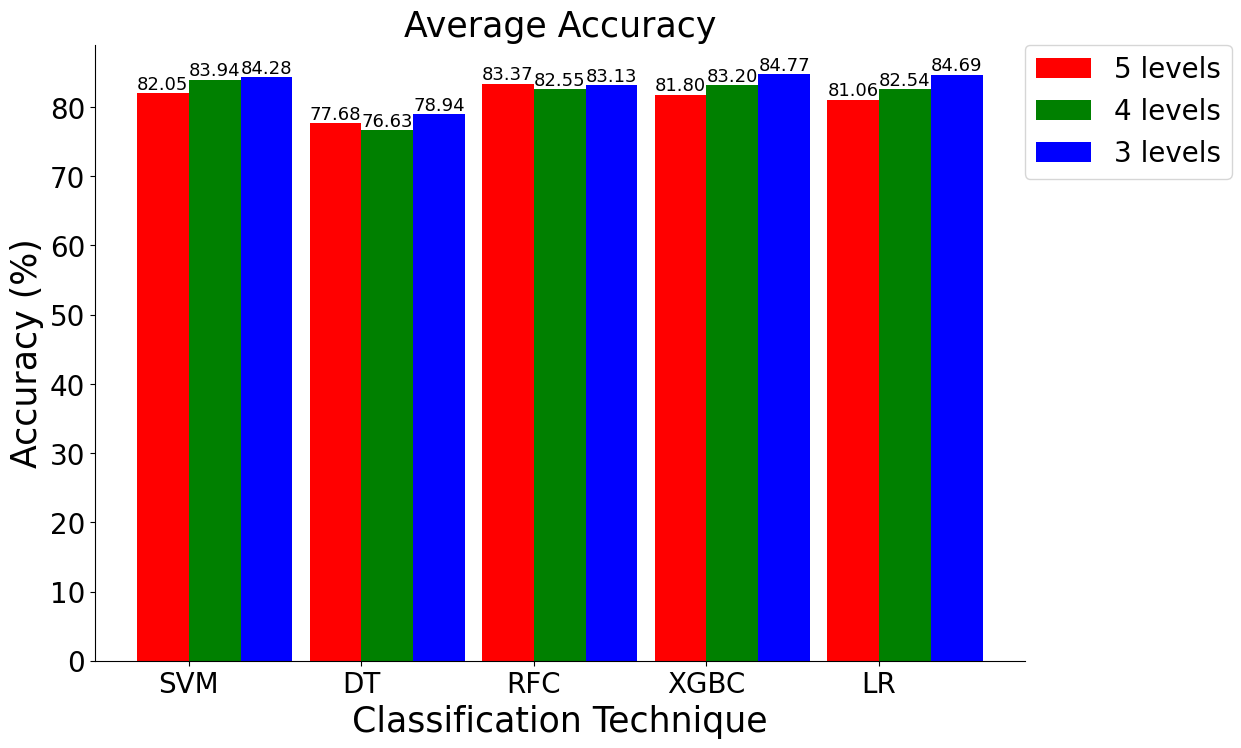

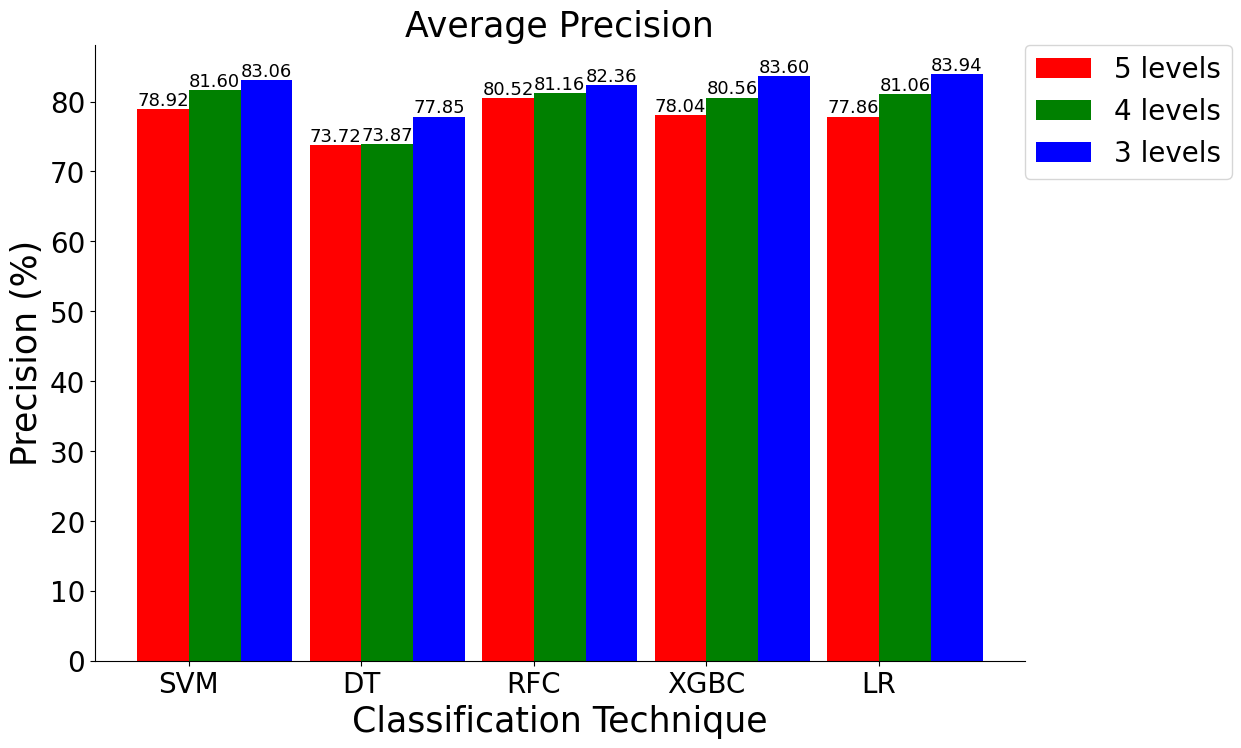

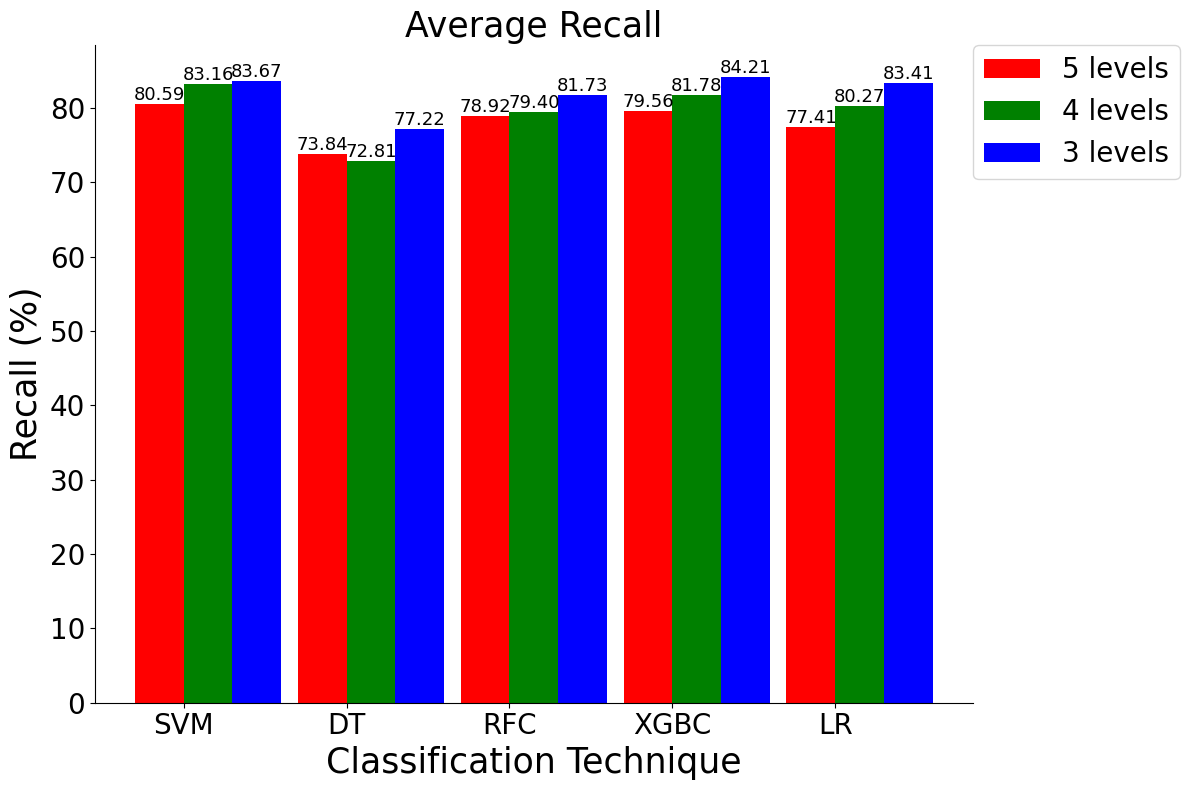

In [42]:
# Set up the bar widths and positions
bar_width = 0.3
index = np.arange(5)

classes_plot = {
                '5 levels':{
                    'bar-index':index,
                    'color':'r',
                },
                '4 levels':{
                    'bar-index':index+bar_width,
                    'color':'g',
                },
                # '3 levels: 1+2+3':{
                #     'bar-index':index+bar_width,
                #     'color':'g',
                # },
                '3 levels':{
                    'bar-index':index+2*bar_width,
                    'color':'b',                 
                }
            }  

plt.figure(figsize=(12, 8))
# plt.subplot(1, 3, 1)

for name in new_classes:
    bar = plt.bar(classes_plot[name]['bar-index'], np.array(new_classes[name]['accuracy'])*100, bar_width, label=name, color=classes_plot[name]['color'])
    add_labels(bar)
plt.xlabel('Classification Technique', fontsize=25)
plt.ylabel('Accuracy (%)', fontsize=25)
plt.title('Average Accuracy', fontsize=25)
plt.xticks(index + bar_width / 2, ('SVM', 'DT', 'RFC', 'XGBC', 'LR'), fontsize=20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=20)

ax = plt.gca() 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='both', labelsize=20)  # Adjust the size as needed

plt.savefig(f'figures/accuracy.svg', format='svg', bbox_inches='tight')


plt.figure(figsize=(12, 8))
for name in new_classes:
    bar = plt.bar(classes_plot[name]['bar-index'], np.array(new_classes[name]['precision'])*100, bar_width, label=name, color=classes_plot[name]['color'])
    add_labels(bar)
plt.xlabel('Classification Technique', fontsize=25)
plt.ylabel('Precision (%)',fontsize=25)
plt.title('Average Precision', fontsize=25)
plt.xticks(index + bar_width / 2, ('SVM', 'DT', 'RFC', 'XGBC', 'LR'), fontsize=20)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=20)

ax = plt.gca() 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='both', labelsize=20)  # Adjust the size as needed

plt.savefig(f'figures/precision.svg', format='svg', bbox_inches='tight')


# plt.subplot(1, 3, 3)
plt.figure(figsize=(12, 8))

for name in new_classes:
    bar = plt.bar(classes_plot[name]['bar-index'], np.array(new_classes[name]['recall'])*100, bar_width, label=name, color=classes_plot[name]['color'])
    add_labels(bar)

plt.xlabel('Classification Technique', fontsize=25)
plt.ylabel('Recall (%)', fontsize=25)
plt.title('Average Recall', fontsize=25)
plt.xticks(index + bar_width / 2, ('SVM', 'DT', 'RFC', 'XGBC', 'LR'), fontsize=20)
# plt.legend(loc='lower left')

# plt.legend(loc='lower left', bbox_to_anchor=(0.7, 1))
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=20)


# Hide the right and top spines
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='both', labelsize=20)  # Adjust the size as needed

plt.savefig(f'figures/recall.svg', format='svg', bbox_inches='tight')


plt.tight_layout()
plt.show()


### CDF